<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 1.2 by Paulo Martins, Vitória Barbosa and Isaac Saito

## Importing Main Libraries

In [94]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# Preprocess data: normalization and ordinal enconder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# For Classification Task
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

We created a github public repository to upload the csv dataset and do software versioning. From github public url, we load the data into a pandas dataframe.

**Data Description:**

US Dollar Index dataset ([Available Here](https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data))

1.   Date: Date of observation (time variable in the format Month DD, YYYY)
2.   Price: Dollar index at market close (continuous and positive variable)
3.   Open: Dollar index at market opening (continuous and positive variable)
4.  High: Highest index value observed on the day (continuous, positive variable)
5. Low: Lowest index value observed on the day (continuous, positive variable)
6. Change %: Change in the dollar index compared to the previous day (continuous variable in percent)

In [95]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/US%20Dollar%20Index%20Historical%20Data.csv'

# Creating pandas dataframe from each dataset
df_dollar = pd.read_csv(dataset_url, names=['date', 'last_price', 'first_price', 'biggest_price', 'lowest_price', 'perc_variation'], skiprows=1, delimiter=',')

# Show some rows
print(df_dollar.head(5).to_markdown())

|    | date         |   last_price |   first_price |   biggest_price |   lowest_price | perc_variation   |
|---:|:-------------|-------------:|--------------:|----------------:|---------------:|:-----------------|
|  0 | Jan 02, 2001 |       108.77 |        109.33 |          109.65 |         108.64 | -0.72%           |
|  1 | Jan 03, 2001 |       110.17 |        108.59 |          110.34 |         108.09 | 1.29%            |
|  2 | Jan 04, 2001 |       108.81 |        110.3  |          110.4  |         108.51 | -1.23%           |
|  3 | Jan 05, 2001 |       108.42 |        108.64 |          109.31 |         108.26 | -0.36%           |
|  4 | Jan 08, 2001 |       108.86 |        108.33 |          109.19 |         108.23 | 0.41%            |


As you can see, the previous dataset there are few features. So we decided to enrich this one using other dataframe, which was filtered for the main 6 currencies based on Euro price:

**Data Description:**

Daily Exchange Rates per Euro ([Available Here](https://www.kaggle.com/datasets/lsind18/euro-exchange-daily-rates-19992020))

1.   Period: Date of observation (time variable in YYYY-MM-DD format)
2.   US dollar: Value of 1 euro in US dollars (continuous and positive variable)
3.   Japanese Yen: Value of 1 euro in Japanese Yen (continuous and positive variable)
4.   Australian dollar: Value of 1 euro in Australian dollar (continuous and positive variable)
5.   Canadian dollar: Value of 1 euro in Canadian dollars (continuous and positive variable)
6.   Swiss franc : Value of 1 euro in Swiss franc (continuous positive variable)
7.   UK pound sterling: Value of 1 euro in pound sterling (continuous and positive variable)
8. Other columns: Value of 1 euro in other currencies (continuous and positive variable). Other currencies are outside the scope of this analysis as they have little impact on the dollar rate, according to the business.

In [96]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/euro-daily-hist_1999_2022.csv'

# Creating pandas dataframe
columns = ['period','australian_dollar','bulgarian_lev','brazilian_real','canadian_dollar','swiss_franc','chinese_yuan',	'cypriot_pound','czech_koruna','danish_krone','estonian_kroon','uk_pound',	'greek_drachma','hk_dollar','croatian_kuna','hungarian_forint',	'indonesian_rupiah','israeli_shekel','indian_rupee','iceland_krona','japanese_yen','korean_won','lithuanian_litas','latvian_lats','maltese_lira','mexican_peso','malaysian_ringgit','norwegian_krone','new_zealand_dollar','philippine_peso','polish_zloty','romanian_leu','russian_rouble','swedish_krona','singapore_dollar','slovenian_tolar','slovak_koruna','thai_baht','turkish_lira','us_dollar','south_african_rand']
df_euro = pd.read_csv(dataset_url, names=columns, skiprows=1, delimiter=',')

# Be sure there are only numeric values into the columns
columns.remove('period')
list_period = df_euro['period']
df_euro = df_euro.loc[:, columns].apply(pd.to_numeric, errors='coerce')
df_euro['date'] = list_period

# Set the most important currencies based on Euro price
#df_euro = df_euro[['date', 'us_dollar', 'japanese_yen', 'uk_pound', 'swiss_franc', 'canadian_dollar', 'australian_dollar']]
print(df_euro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6655 entries, 0 to 6654
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   australian_dollar   6593 non-null   float64
 1   bulgarian_lev       6195 non-null   float64
 2   brazilian_real      6326 non-null   float64
 3   canadian_dollar     6593 non-null   float64
 4   swiss_franc         6593 non-null   float64
 5   chinese_yuan        6326 non-null   float64
 6   cypriot_pound       2304 non-null   float64
 7   czech_koruna        6593 non-null   float64
 8   danish_krone        6593 non-null   float64
 9   estonian_kroon      3074 non-null   float64
 10  uk_pound            6593 non-null   float64
 11  greek_drachma       514 non-null    float64
 12  hk_dollar           6593 non-null   float64
 13  croatian_kuna       5880 non-null   float64
 14  hungarian_forint    6593 non-null   float64
 15  indonesian_rupiah   6593 non-null   float64
 16  israel

In [97]:
# Merge both dataframe
df_euro['date'] = pd.to_datetime(df_euro['date']).dt.strftime('%Y-%m-%d')
df_dollar['date'] = pd.to_datetime(df_dollar['date']).dt.strftime('%Y-%m-%d')
df_enriched = pd.merge(df_dollar, df_euro, on=['date'], how='inner')
df_euro = None
df_dollar = None

# Just checking that the dataframe was loaded correctly from the Github URL
print(df_enriched.head(5).to_markdown())

|    | date       |   last_price |   first_price |   biggest_price |   lowest_price | perc_variation   |   australian_dollar |   bulgarian_lev |   brazilian_real |   canadian_dollar |   swiss_franc |   chinese_yuan |   cypriot_pound |   czech_koruna |   danish_krone |   estonian_kroon |   uk_pound |   greek_drachma |   hk_dollar |   croatian_kuna |   hungarian_forint |   indonesian_rupiah |   israeli_shekel |   indian_rupee |   iceland_krona |   japanese_yen |   korean_won |   lithuanian_litas |   latvian_lats |   maltese_lira |   mexican_peso |   malaysian_ringgit |   norwegian_krone |   new_zealand_dollar |   philippine_peso |   polish_zloty |   romanian_leu |   russian_rouble |   swedish_krona |   singapore_dollar |   slovenian_tolar |   slovak_koruna |   thai_baht |   turkish_lira |   us_dollar |   south_african_rand |
|---:|:-----------|-------------:|--------------:|----------------:|---------------:|:-----------------|--------------------:|----------------:|-----------------:|--

## Data Exploration
On this stage, we will get knowlodge on data. So, we'll check the type of columns and how many null values there are; since this point, all next exploratory analysis will be under numerics columns: check descriptive statistics, density distribution and outliers occurrences by IQR.

In [98]:
# Show descriptive statistics
print(df_enriched.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5569 entries, 0 to 5568
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                5569 non-null   object 
 1   last_price          5569 non-null   float64
 2   first_price         5569 non-null   float64
 3   biggest_price       5569 non-null   float64
 4   lowest_price        5569 non-null   float64
 5   perc_variation      5569 non-null   object 
 6   australian_dollar   5533 non-null   float64
 7   bulgarian_lev       5533 non-null   float64
 8   brazilian_real      5533 non-null   float64
 9   canadian_dollar     5533 non-null   float64
 10  swiss_franc         5533 non-null   float64
 11  chinese_yuan        5533 non-null   float64
 12  cypriot_pound       1764 non-null   float64
 13  czech_koruna        5533 non-null   float64
 14  danish_krone        5533 non-null   float64
 15  estonian_kroon      2533 non-null   float64
 16  uk_pou

To increase the possibilities, we will do some feature engineering, creating 3 new columns (day, month and year) and transform the perc_variation column from object to float64.

In [99]:
# Ordering the data
df_enriched.sort_values(by=['date'], ascending=True)

# Create 3 new features
df_enriched['date'] = pd.to_datetime(df_enriched['date'])
df_enriched['day'] = df_enriched['date'].dt.day
df_enriched['month'] = df_enriched['date'].dt.month
df_enriched['year'] = df_enriched['date'].dt.year

# Remove '%'symbol from pec_variation column
df_enriched['perc_variation'] = df_enriched['perc_variation'].str[:-1]
df_enriched['perc_variation'] = df_enriched['perc_variation'].astype(float)

df_enriched.drop(columns=['date'], axis=1, inplace=True)

**Feature Selection**

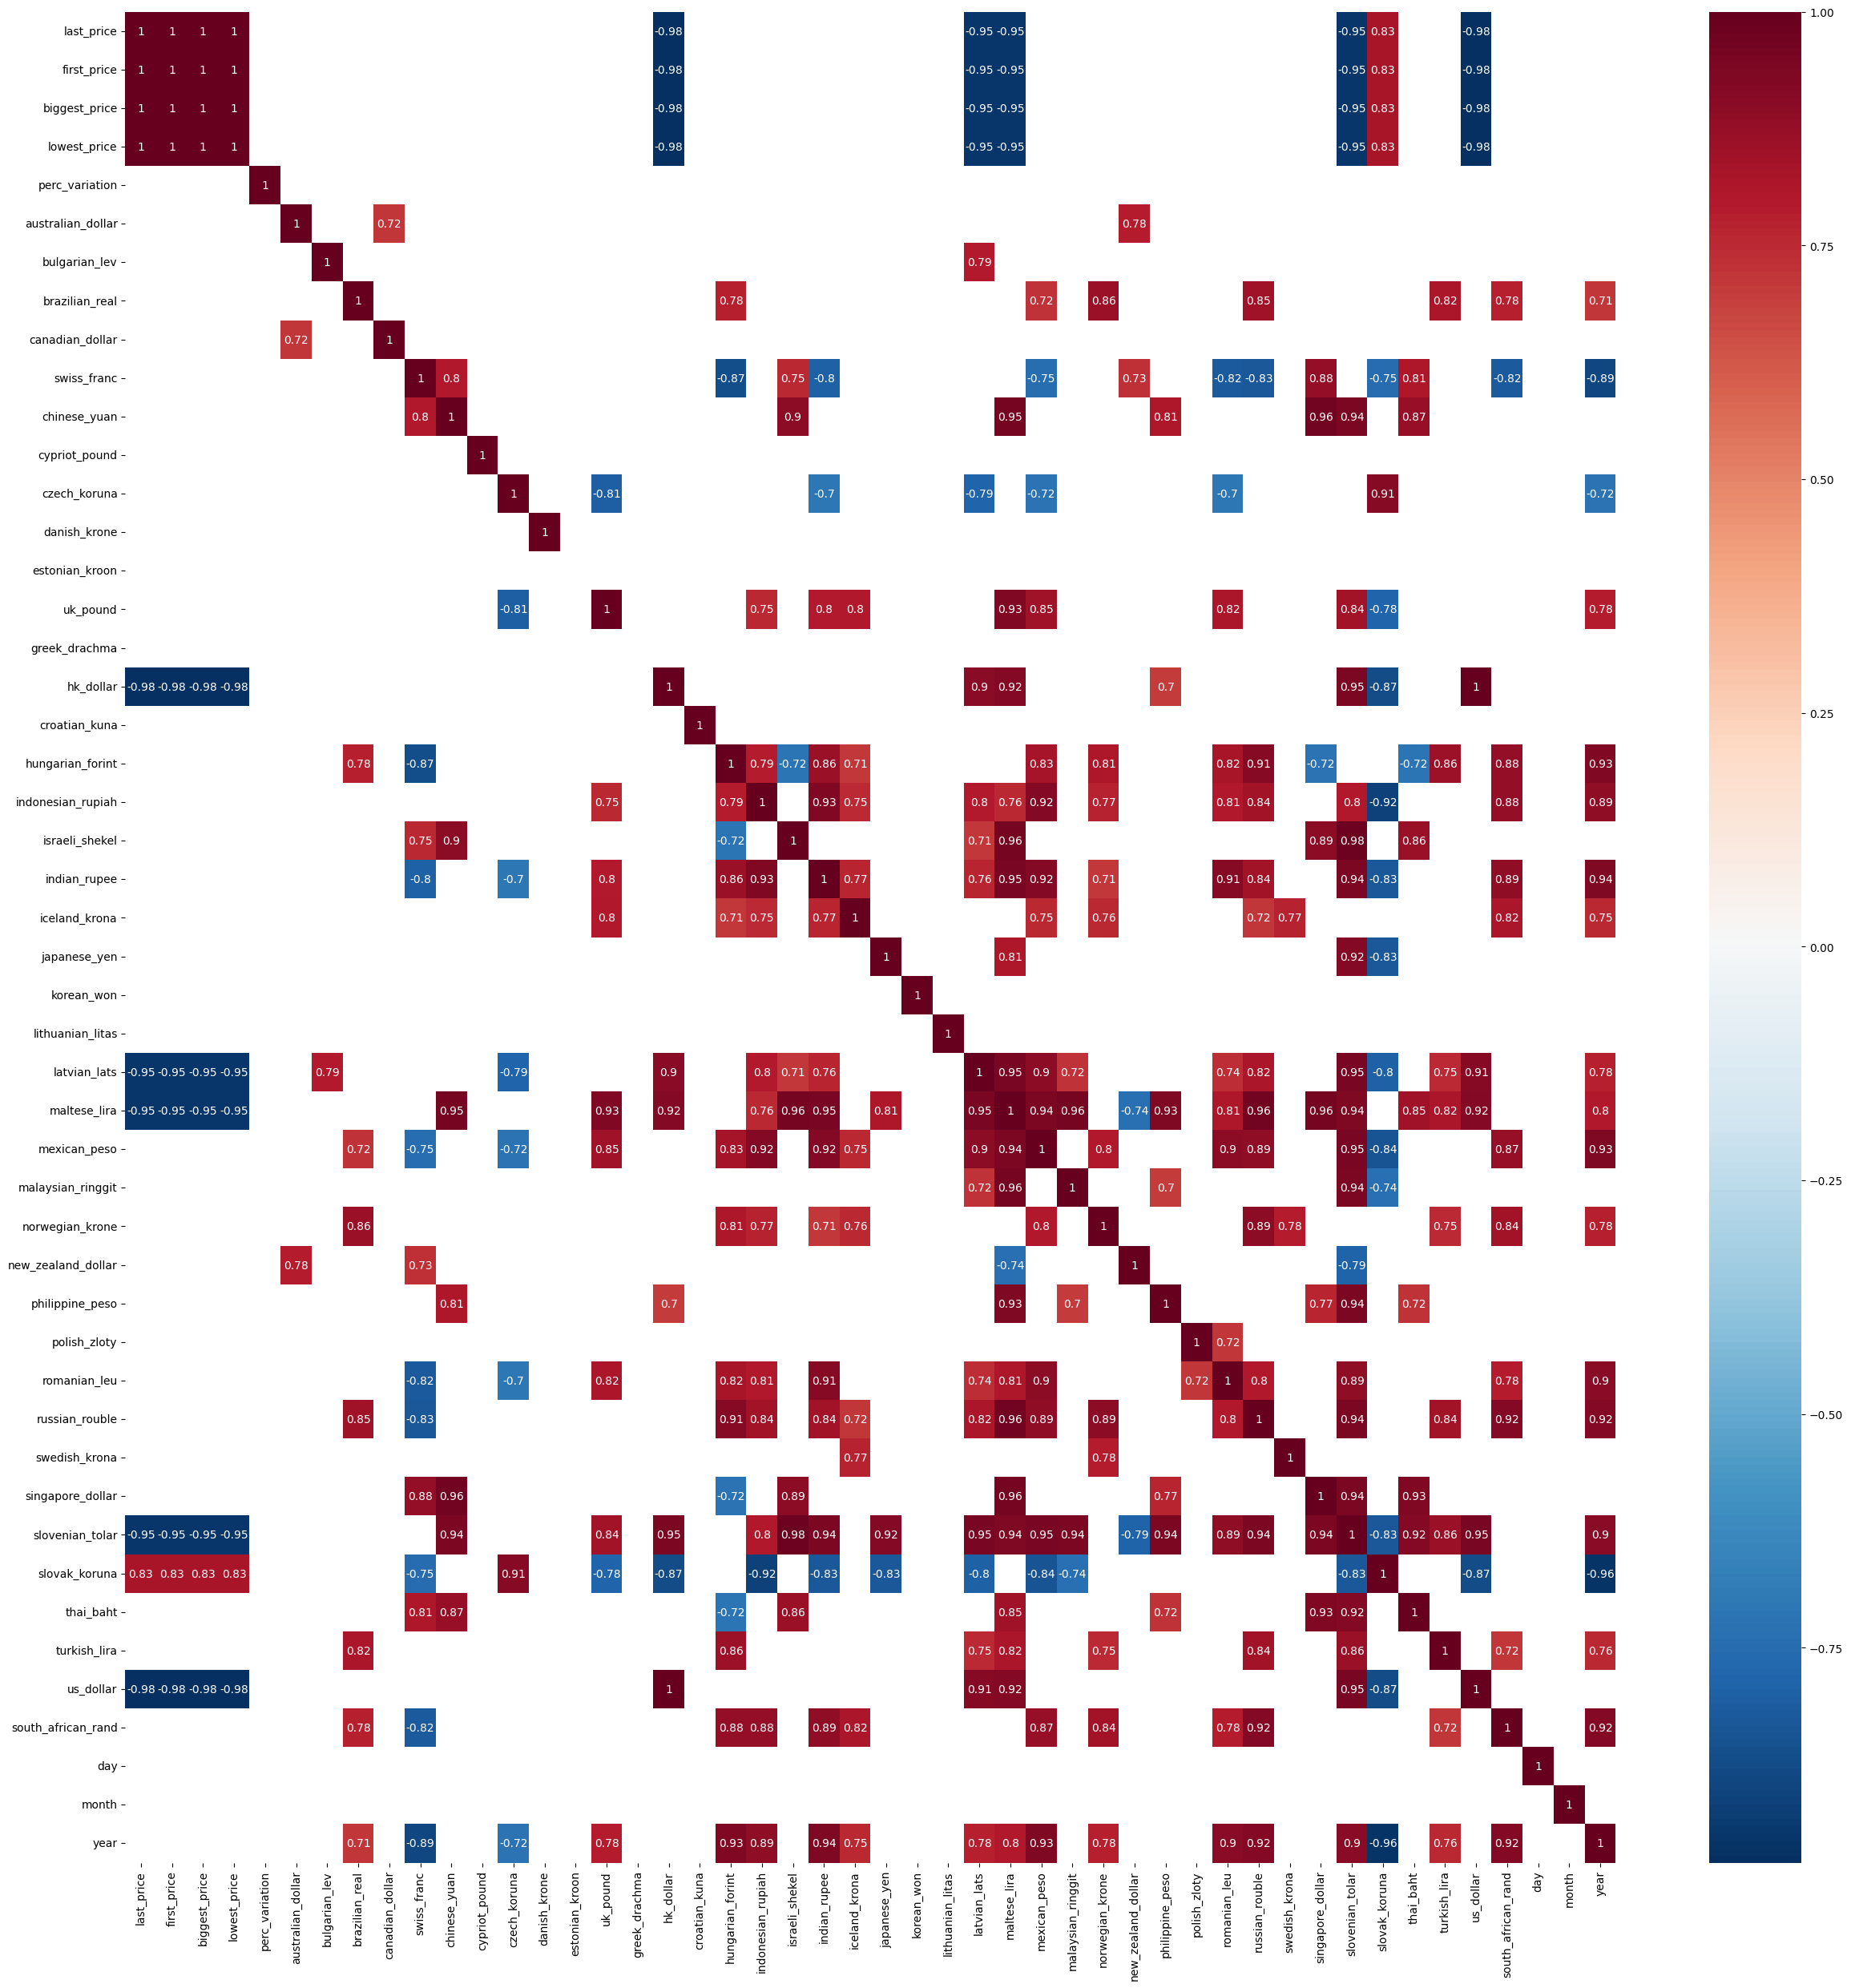

In [113]:
# Correlation matrix for strongly correlated positive or negative values
plt.figure(figsize=(30, 30))
correlation_matrix = df_enriched.corr()
mask = (correlation_matrix > 0.70) | (correlation_matrix < -0.70)
sns.heatmap(correlation_matrix[mask], annot=True, cmap='RdBu_r')
plt.show()

In [114]:
# CONTINUE FROM HERE

# Check the mask and accumulate columns to remove
list_features = df_enriched.columns.to_list()
for col in correlation_matrix.columns:
    if mask[col].any():  # If any value in the column satisfies the mask
        list_features.remove(col)

df_cleaned = df_enriched.loc[:, list_features].copy()
print(df_cleaned.shape)

(5569, 2)


In [100]:
# Checking the Descriptive Statistics of numerics columns
print(df_enriched.describe())

        last_price  first_price  biggest_price  lowest_price  perc_variation  \
count  5569.000000  5569.000000    5569.000000   5569.000000     5569.000000   
mean     90.478107    90.476624      90.801855     90.158425        0.001219   
std      10.708799    10.708629      10.741821     10.677336        0.485459   
min      71.330000    71.330000      71.690000     70.700000       -3.020000   
25%      81.430000    81.420000      81.690000     81.170000       -0.280000   
50%      89.940000    89.930000      90.230000     89.620000        0.000000   
75%      96.930000    96.920000      97.230000     96.600000        0.270000   
max     120.900000   120.760000     121.020000    119.860000        2.560000   

       australian_dollar  bulgarian_lev  brazilian_real  canadian_dollar  \
count        5533.000000    5533.000000     5533.000000      5533.000000   
mean            1.572534       1.954730        3.463612         1.465625   
std             0.155623       0.002811        1.17

ValueError: `dataset` input should have multiple elements.

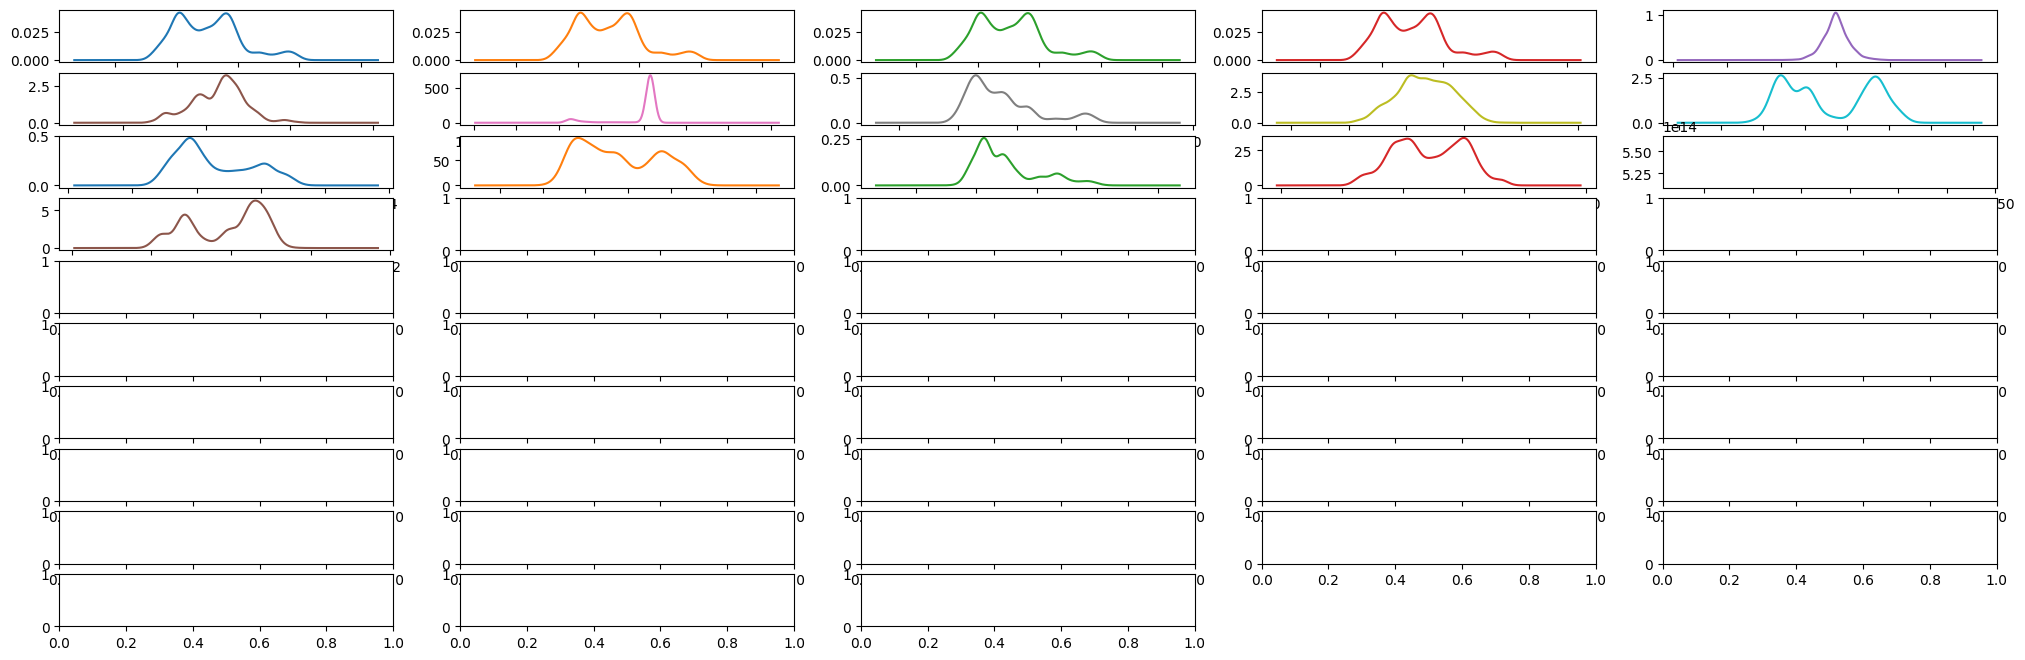

In [102]:
# Now let's check the density distribution of numeric columns
df_enriched.plot(kind = 'density', subplots = True, layout = (10,5), sharex = False, figsize = (25, 8))
plt.show()

In [ ]:
# Finally verifying if there is any outlier values based on IQR technique
df_enriched.plot(kind = 'box', subplots = True, layout = (10,5), sharex = False, sharey = False, figsize = (20,8))
plt.show()

We know that the currency market is volatile and perhaps the discrepant values identified in the perc_variation column are a reflection of the market. Just for verification purposes, we will recalculate all the values in this column according to the official documentation

In [ ]:
df_enriched['calculated_perc_variation'] = 100 * ((df_enriched['last_price'] / df_enriched['last_price'].shift()) - 1)
df_enriched.loc[0, 'calculated_perc_variation'] = df_enriched.loc[0, 'perc_variation']
print(df_enriched[['perc_variation', 'calculated_perc_variation']].describe())

Based on the descriptive statistics above, we can see that the change was not very significant. In general, the data has changed from the third decimal place. Since we've to decide on one of the two columns, we'll keep the value of calculated_perc_variation by replacing the values in perc_variation.

In [ ]:
# Just deciding on one of the two
df_enriched['perc_variation'] = df_enriched['calculated_perc_variation']
df_enriched.drop(columns=['calculated_perc_variation'], axis=1, inplace=True)

As we expected, this kaggle dataset has been pre-processed by someone and this version looks good enough to go ahead without any additional pre-processing, such as filling in missing values or removing outliers.

## Problem definition

At this point, we only have a clean dataframe from kaggle and did some feature engineering. Now we'll decide for 6 categories that explain the percentage of variation. To find out the threshould, we'll plot a histogram chart over that column.

In [ ]:
# Find out the classes of problems
df.perc_variation.hist(bins=5)

Based on histogram, the 5 categories are:


1.   A: Less than -2
2.   B: Less than -1
3.   C: Less than 0
4.   D: Less than 1
5.   E: Less than 2
6.   F: Greater equal to 2



In [ ]:
# Creating the conditions for each category and then apply it for the column value
choices = ['1', '2', '3', '4', '5', '6']
conditions = [
    df['perc_variation'].lt(-2),
    (df['perc_variation'].ge(-2)) & (df['perc_variation'].lt(-1)),
    (df['perc_variation'].ge(-1)) & (df['perc_variation'].lt(0)),
    (df['perc_variation'].ge(0)) & (df['perc_variation'].lt(1)),
    (df['perc_variation'].gt(1)) & (df['perc_variation'].le(2)),
    df['perc_variation'].ge(2)
]

df['category'] = np.select(conditions, choices, default=np.nan)

### Feature Selection and Normalization

As you can see above, there are four strongly related columns, so we have to decide on one of them. We selected first_price because it is weakly related to other columns. Finally, we'll normalize the column values.

In [ ]:
list_features = ['first_price', 'perc_variation', 'day', 'month', 'year', 'category']
df_normalized = df.loc[:, list_features].copy()

scaler = MinMaxScaler()
# Avoiding category column
for i in range(0,df_normalized.shape[1] - 1):
  df_normalized.iloc[:, i] = scaler.fit_transform(df_normalized.iloc[:, [i]])

At this point, we expect that there are only uncorrelated variables (close to 0) to feed the linear regression algorithm. Let's check it:

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_normalized.corr(), annot=True, cmap='RdBu_r')
plt.show()

### Forecast Prediction with KNN and Logaritmic Regression

For this point, we'll create 3 distinct dataframe, one for each target (7, 14, 28) and then calculate the target column.

In [ ]:
# Removing null values
mask = df_normalized.category.notna()
df_predict = df_normalized[mask]

# Stratified Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(df_predict.iloc[:, :-1], df_predict.iloc[:, -1], test_size=0.2, random_state=7, stratify=df_predict.iloc[:, -1])

categories = df_predict.iloc[:, -1].unique()
n_categories = len(categories[0])
knn = KNeighborsClassifier(n_neighbors=n_categories)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {100 * accuracy:.1f}%")